In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # removal rate of asymptomatic infectives
gIs   = 1./7            # removal rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sir_latent_traj.npy', data_array)

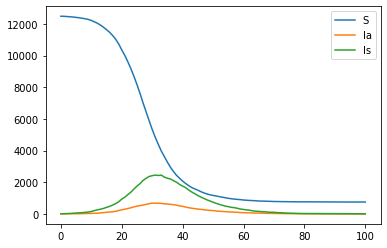

In [3]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

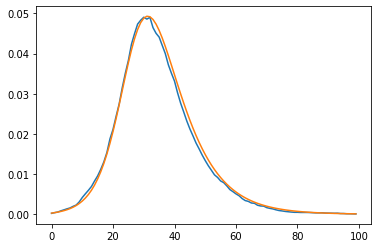

In [4]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('sir_latent_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()

In [5]:
# Cut the observed data 
Tf_inference = 20 
Nf_inference = Tf_inference+1 
obs = obs[:Nf_inference]

start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-289.97449095589934
0.17074298858642578


In [6]:
eps = 1e-4

# make parameter guesses and set up bounds for each parameter 
alpha_g = 0.3
alpha_std = 0.2 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.04 
beta_bounds = (eps, 1)

gIa_g = 0.2
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.2
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

# not inferred 
fsa_g = 0.8

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)


Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=963881, Thu May  7 22:29:25 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 4.150688236736625e+01 1.0e+00 9.58e-01  4e-04  2e-01 0:01.4
    2     32 -3.227005254771349e+02 1.2e+00 9.75e-01  4e-04  2e-01 0:03.1
    3     48 5.203528190049084e+01 1.4e+00 1.01e+00  4e-04  2e-01 0:04.4
    6     96 -3.230714576187860e+02 1.9e+00 9.37e-01  4e-04  2e-01 0:08.2
   10    160 -3.312177212578664e+02 2.5e+00 7.29e-01  3e-04  2e-01 0:12.8
   15    240 -3.241710740353759e+02 3.7e+00 5.72e-01  2e-04  1e-01 0:17.9
Optimal value (global minimisation):  -331.2177212578664
Starting local minimisation...
Optimal value (local minimisation):  -332.95556777743997
25.055483102798462


In [7]:
np.save('latent_SIR_params.npy', params)

In [8]:
params = np.load('latent_SIR_params.npy')
print('best estimates for params: ', params[:4])
print('best estimates for initial conditions: ', params[4:])

best estimates for params:  [0.23795565 0.01928502 0.074864   0.16229778]
best estimates for initial conditions:  [2.49500214e-01 7.49500484e-01 2.31466872e-04 2.71237241e-04
 1.94642517e-04 2.04820526e-04]


**Warning: For latent forecasting, the resulting Hessian is sometimes not positive definite. This is a known issue that is being worked on.**

In [9]:
hess_params, hess_init = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, 
                                                  Tf_inference, Nf_inference, contactMatrix, 
                                                 beta_rescale=2, eps=1e-5)

In [10]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

In [11]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'S0':params[4: 4+M],
            'Ia0':params[4+M:4+2*M],
            'Is0':params[4+2*M:],
              'fsa':fsa,
             'cov_params':cov_params,
             'cov_init':cov_init}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR_latent(parameters, M, Ni)

In [12]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1




result_forecast = model_forecast.simulate(contactMatrix, Tf, Nf,
                                      verbose=True,
                                     Ns=Ns)

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] #+ Tf_inference

Finished. Time needed for evaluation: 00:00:01


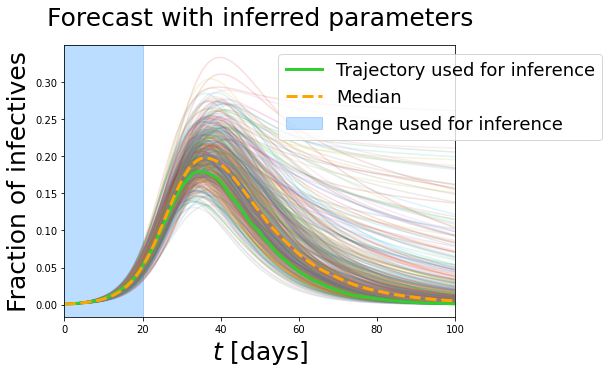

In [13]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,M:3*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


data_array = np.load('sir_latent_traj.npy')

cur_trajectory_underlying = np.sum( data_array[:,M:3*M] ,axis=1 )
#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    #print(e)
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show(fig)
plt.close(fig)